[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/docs/tutorials/gaussian_errors.ipynb)
[![Open on Github](https://img.shields.io/badge/github-Open%20on%20Github-black?logo=github)](https://github.com/jfcrenshaw/pzflow/blob/main/docs/tutorials/gaussian_errors.ipynb)

If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In addition, uncomment and run the following code:

In [1]:
# !pip install pzflow matplotlib

------------------
## Convolving Gaussian errors

This notebook demonstrates how to train a flow on data that has Gaussian errors/uncertainties, as well as convolving those errors in log_prob and posterior calculations.
We will use the two moons data set again.

In [1]:
from pzflow import Flow
from pzflow.examples import get_twomoons_data

import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.facecolor"] = "white"

Let's load the two moons data again.
This time, we will add columns for errors.
Let's set them at the 10% level.

In [3]:
# load the data
data = get_twomoons_data()
# 10% errors
data["x_err"] = 0.10 * jnp.abs(data["x"].values)
data["y_err"] = 0.10 * jnp.abs(data["y"].values)
data

,x,y,x_err,y_err
0,-0.748695,0.777733,0.074870,0.077773
1,1.690101,-0.207291,0.169010,0.020729
2,2.008558,0.285932,0.200856,0.028593
3,1.291547,-0.441167,0.129155,0.044117
4,0.808686,-0.481017,0.080869,0.048102
...,...,...,...,...
99995,1.642738,-0.221286,0.164274,0.022129
99996,0.981221,0.327815,0.098122,0.032781
99997,0.990856,0.182546,0.099086,0.018255
99998,-0.343144,0.877573,0.034314,0.087757


Notice how I saved the errors in columns with the suffix "_err".
Anytime you tell PZFlow to convolve errors (see below), it will look for columns with "_err" suffixes.
If it can't find an error column for a certain variable, it will assume that variable has zero error.
It is also important to know that PZFlow will assume the errors are Gaussian, unless you explicitly tell it otherwise, [like in this example](https://github.com/jfcrenshaw/pzflow/blob/main/examples/nongaussian_errors.ipynb).

Also, note that I didn't actually add the Gaussian noise to the `x` and `y` variables themselves.
This is just so we can clearly see the effects of convolving errors below.
The initial data will be noiseless, but since we will convolve errors during training, the samples from the trained flow will be noisy.

Here is the noiseless data:

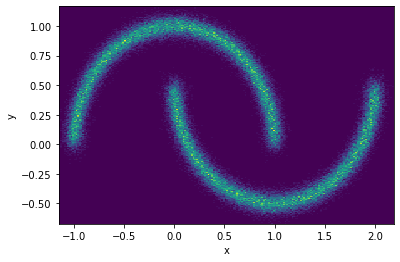

In [4]:
plt.hist2d(data['x'], data['y'], bins=200)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now we will build the same flow we built in the Intro.

In [5]:
flow = Flow(["x", "y"])

This time during training, we will set `convolve_errs=True`.
This means that during each epoch of training, we will resample the training set from the Gaussian distributions set by `x_err` and `y_err`.

In [6]:
%%time
losses = flow.train(data, convolve_errs=True, verbose=True)

Training 100 epochs 
Loss:
(0) 2.3212
(1) 0.8941
(6) 0.6283
(11) 0.6253
(16) 0.6220
(21) 0.5972
(26) 0.6049
(31) 0.5934
(36) 0.6154
(41) 0.5999
(46) 0.6087
(51) 0.5977
(56) 0.6036
(61) 0.5937
(66) 0.5781
(71) 0.5865
(76) 0.5848
(81) 0.5930
(86) 0.5863
(91) 0.5867
(96) 0.6018
(100) 0.6002
CPU times: user 5min 13s, sys: 48 s, total: 6min 1s
Wall time: 1min 22s


Now let's plot the training losses to make sure everything looks like we expect it to...

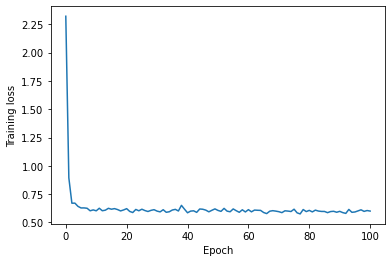

In [7]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

Perfect!

Now we can draw samples from the flow, using the `sample` method.

In [8]:
samples = flow.sample(10000, seed=0)

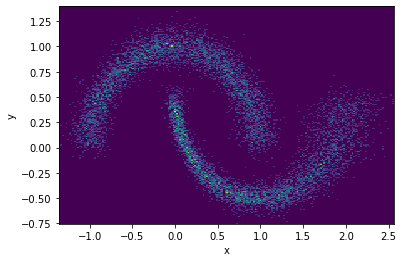

In [9]:
plt.hist2d(samples['x'], samples['y'], bins=200)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Notice how the learned distribution is noisy - that is because we resampled the training set from the Gaussian error distributions on each epoch of training.
In particular, notice how the noise increases as the magnitude of $x$ and $y$ increases - this is exactly what we expected by setting the error of each to 10% of the true value.

We can also calculate posteriors with error convolution by setting the `err_samples` parameter.
E.g. setting `err_samples=100` tells the posterior method to draw 100 samples from the Gaussian error distribution for each galaxy, calculate posteriors for each of those samples, and then average over the samples.

Below, we will select one galaxy and calculate the posterior for various values of `err_samples`.

In [10]:
grid = jnp.linspace(-2, 2, 100)
pdfs = dict()
for err_samples in [1, 10, 100, 1000, 10000]:
    pdfs[err_samples] = flow.posterior(data[:1], column="x", grid=grid, err_samples=err_samples, seed=0)[0]

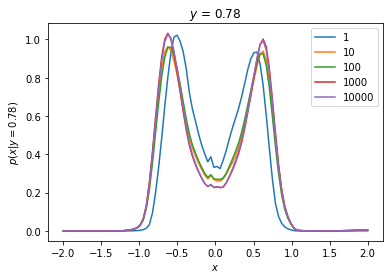

In [11]:
for i, pdf in pdfs.items():
    plt.plot(grid, pdf, label=i)
plt.legend()
plt.title(f"$y$ = {data['y'][0]:.2f}")
plt.xlabel("$x$")
plt.ylabel("$p(x|y=0.78)$")
plt.show()

We can see how drawing more samples in the error convolution smooths out the posterior as you might expect.

Note that the `log_prob` method works identically.